K-Means Clustering Algorithm (Completed July, 2018):

The following code will demonstrate my take on the k-means algorithm using the well known IRIS dataset. This is the first of my coding-from-scratch projects that I won't be too embarrassed to show the public. 

Key achievements from this project:
1. How the K-means algorithm worked.
2. Coding various functions and piecing them together.
3. Exploration of the IRIS dataset.
4. Graphically presenting the iteration of the K-means algorithm.
5. Applying correlations to the identified clusters. In this iris dataset, I have clustered the set on the first two features and run correlations using ANOVA on the remaining two. The practical value in demonstrating this is to begin building the story of what these unsupervised clusters could actually be a representation of in real life. In this IRIS example, it could simply be identifing flowers that have bigger or smaller petals. 

In [21]:
#Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import random

In [22]:
#functions

#normalisation function to standardise all data between 0 and 1
def normalise(data):
    number_columns = data.shape[1]
    normalised_data = pd.DataFrame()
    for i in range(number_columns):
        maximum = np.max(data.iloc[:,i])
        minimum = np.min(data.iloc[:,i])
        #mean = np.mean(data.iloc[:,i])
        new_col = (data.iloc[:,i] - minimum) / (maximum - minimum)
        normalised_data = pd.concat([normalised_data, new_col], axis = 1)
    return normalised_data

#kmeans functions

def initiate_kmeans(data, k):
    #initiate random starting positions.
    data = pd.DataFrame(data)
    initial_positions = np.random.rand(k, data.shape[1])  
    
    #For this function there are more efficient ways of choosing the initialisation 
    #points such as choosing points that are the furthest distance away, or using
    #one point that is the mean of the entire dataset. 
    #This optimisation area is the beyond the scope of my investigation into k-means.
   
    distance_table = pd.DataFrame()
    
    #calculate distance metrics - change metric here if required. Euclidean distance is used here.
    for init in initial_positions:
        distances = pd.DataFrame(np.sum((data - init)**2, axis = 1))
        distance_table = pd.concat([distance_table, distances],axis = 1)
    distance_table.columns = range(0,k)
    #append assigned, interim labels
    labels = []
    
    for i in range(0, data.shape[0]):
        labels.append(np.argmin(distance_table.iloc[i,:]))
    interim_clusters = pd.DataFrame(labels)
    interim_clusters.columns = ['labels']
    data_with_labels = pd.concat([data, interim_clusters], axis = 1)
    return data_with_labels, initial_positions

def plot_progress(data, centroid_positions):
    centroid_positions = pd.DataFrame(centroid_positions)
    plt.scatter(data.iloc[:,0], data.iloc[:,1], c = data.iloc[:,-1])
    plt.scatter(centroid_positions.iloc[:,0], centroid_positions.iloc[:,1], c = 'r', marker = 'X', s = 350)
    plt.title('K-means Iteration Plot')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()    

def loop_kmeans(data_with_labels, initial_positions, k, max_iterations, progress_plot = True):
    data = data_with_labels.iloc[:,:-1]
    converge_values1 = np.ones(k)
    converge_values2 = np.zeros(k)
    #converge methodology is to check when the labels for each data point stop shifting and the next iteration does
    #not present any change in labels
    max_iter_count = 0
    if progress_plot == True:
        plot_progress(data_with_labels, initial_positions)
    while np.array_equal(converge_values1, converge_values2) == False:
        converge_values2 = converge_values1
        #calculate centroids
        interim_positions_df = pd.DataFrame()
        for i in range(0, k):
            centroid_calc = data_with_labels.loc[data_with_labels.loc[:,'labels'] == i, :]
            centroid_calc = centroid_calc.iloc[:,:-1]
            new_centroid = pd.DataFrame(np.mean(centroid_calc, axis = 0))
            new_centroid.columns = [i]                   
            new_centroid = new_centroid.T
            interim_positions_df = pd.concat([interim_positions_df,new_centroid], axis = 0)
        interim_positions = interim_positions_df.values
        #recalculate distances based on new centroids
        distance_table = pd.DataFrame()
        #change distance measure here if required
        for inter_positions in interim_positions:
            distances = pd.DataFrame(np.sum((data - inter_positions)**2, axis = 1))
            distance_table = pd.concat([distance_table, distances], axis = 1)
        distance_table.columns = range(0,k)
        labels = []
        for i in range(0,data.shape[0]):
            labels.append(np.argmin(distance_table.iloc[i,:]))
        interim_clusters = pd.DataFrame(labels)
        interim_clusters.columns = ['labels']
        #converge conditions
        converge_values1 = interim_clusters.iloc[:,0].value_counts().values
        data_with_labels = pd.concat([data, interim_clusters], axis = 1)    
        if progress_plot == True:
            plot_progress(data_with_labels, interim_positions)
        max_iter_count += 1
        if max_iter_count == max_iterations:
            break
        k_means_labels = data_with_labels.loc[:,'labels']
    return k_means_labels

#function to tie it all together
def run_kmeans(data, k, initialisation_number = 30, max_iterations = 100, progress_plot = False):
    results = pd.DataFrame()
    if progress_plot == True:
        plot_option = True
    else:
        plot_option = False
    for i in range(0, initialisation_number):
        data_with_labels, initial_positions = initiate_kmeans(data, k)
        kmeans_results = loop_kmeans(data_with_labels, initial_positions, k, max_iterations = 30, progress_plot = plot_option)
        results = pd.concat([results, kmeans_results], axis = 1)
        count_list = []
        unique_list = []
        combinations = []
        for i in range(results.shape[1]):
            label_combination_assignments = results.iloc[:,i]
            label_combination = np.sort(label_combination_assignments.value_counts().values)
            if any((label_combination == x).all() for x in count_list) == False:
                unique_list.append(label_combination)
                combinations.append(label_combination_assignments.values)
            count_list.append(label_combination)
        best_result = []
        for combination in unique_list:
            counter = 0
            for row in count_list:
                if np.array_equal(combination,row):
                    counter += 1
            best_result.append(counter)
        best_result_index = best_result.index(np.max(best_result))
        kmean_final_result = combinations[best_result_index]
    return kmean_final_result
    

In [23]:
#explore the iris dataset

#load iris dataset
iris = datasets.load_iris()

#put into dataframes
iris_data = pd.DataFrame(iris.data)
iris_data.columns = iris.feature_names
labels = pd.DataFrame(iris.target)
labels.columns = ['Labels']

print(iris_data.head())
#there are 4 features
print(iris_data.columns)
#these are their names
print(labels.Labels.unique())
#there are 3 unique classes in this dataset


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
[0 1 2]


C:\Users\Harrison\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


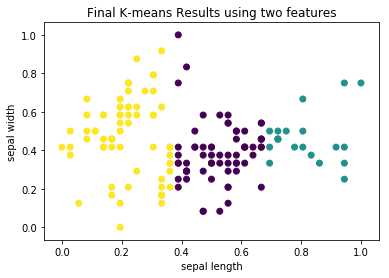

In [24]:
#run kmeans on the iris dataset

#load iris dataset
iris = datasets.load_iris()

#put into dataframes
iris_data = pd.DataFrame(iris.data)
iris_data.columns = iris.feature_names
labels = pd.DataFrame(iris.target)
normalised_col_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

#normalise data for more effective kmeans and select number of columns to use
norm_data = normalise(iris_data).values
norm_data_df = normalise(iris_data)
norm_data_df.columns = normalised_col_names
norm_data_df.head()

#select number of clusters

k = 3

#run kmeans using the first two features of the dataset (sepal length and sepal width), toggle progress_plot if required.
results = run_kmeans(norm_data_df.iloc[:, 0:1], k = 3, initialisation_number = 20, max_iterations = 50, progress_plot = False)

#plot results
plt.scatter(norm_data_df.iloc[:,0], norm_data_df.iloc[:,1], c = results)
plt.title('Final K-means Results using two features')
plt.xlabel(norm_data_df.columns[0])
plt.ylabel(norm_data_df.columns[1])
plt.show()    


F_onewayResult(statistic=158.3935211132015, pvalue=2.10574713320909e-37)
F_onewayResult(statistic=118.70863243980016, pvalue=2.0644867565413535e-31)


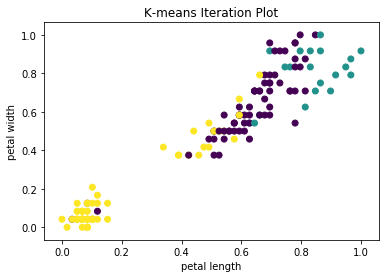

In [25]:
#correlation exercise to identify if any relationships exist between the clusters learned and any available external data
#in this case, I will use the two other features not used when running kmeans above (petal length and petal width)

from scipy import stats

data_with_labels = pd.concat([norm_data_df, pd.DataFrame(results)], axis = 1)
data_with_labels.head()
data_with_labels.loc[data_with_labels.loc[:,0] == 0, 'petal length']
data_with_labels.columns
 
petal_length_corrs = stats.f_oneway(
data_with_labels.loc[data_with_labels.loc[:,0] == 0, 'petal length'], 
data_with_labels.loc[data_with_labels.loc[:,0] == 1, 'petal length'], 
data_with_labels.loc[data_with_labels.loc[:,0] == 2, 'petal length'])
print(petal_length_corrs)
#results show that petal length has a significant effect on species type.
#the f-score is high (~610) and p-value <0.05
                     
petal_width_corrs = stats.f_oneway(
data_with_labels.loc[data_with_labels.loc[:,0] == 0, 'petal width'], 
data_with_labels.loc[data_with_labels.loc[:,0] == 1, 'petal width'], 
data_with_labels.loc[data_with_labels.loc[:,0] == 2, 'petal width'])
print(petal_width_corrs)
#results show that petal width have a significant effect on species type.
#the f-score is high (~392) and p-value <0.05

#validate these results via plotting
plt.scatter(norm_data_df.iloc[:,2], norm_data_df.iloc[:,3], c = results)
plt.title('K-means Iteration Plot')
plt.xlabel(norm_data_df.columns[2])
plt.ylabel(norm_data_df.columns[3])
plt.show()

In summary, the correlations showed that both of the remaining features (petal length and width) are actually significantly
correlated when describing the identified clusters. This is especially true for one of the clusters (clustered on the bottom left) whilst the remaining 2 clusters show relatively less (but still noticeable) correlation.